# Test of bespoke neural network

Import necessary modules:

In [1]:
from classes.MyModel import MyModel
import torch
import torch.nn as nn
import math as math
from pathlib import Path
import numpy as np
from torchviz import make_dot

from modules.helper_functions_tsp import (find_problem_size,
load_dict_from_json, read_file_name, validate_distance_array,
cost_fn_fact, cost_fn_tensor, hot_start, hot_start_list_to_string)

from modules.config import NETWORK_DIR, DATA_SOURCES, GRAPH_DIR
from modules.helper_ML_functions import find_device
from modules.graph_functions import (plot_sine_activation,
                                     plot_model_training)

Set up constants:

In [2]:
LOCATIONS = 8                       #locations in problem
DECODING_FORMULATION = 'original'   #decoding formulation
                                    #options: 'original', 'new'
GRAY = False                        #gray code  
STD_DEV = 0.5                       #standard deviation for weight randomization
NUM_EPOCHS = 1000                   #number of epochs for training
NUM_LAYERS = 2                      #number of layers in the mode
LR = 0.0001                         #Learning rate
VERBOSE = False                     #controls how much output the model produces
BATCH_SIZE = 64                     #size of input tensor.  Reduces randomness
MOMENTUM = 0.0                      #momentum for optimizer
WEIGHT_DECAY = 0.0002               #importance of L2 regularization in optimiser
OPTIMIZER = 'RMSprop'               #optimizer to use
                                    #options: 'Adam', 'SGD', 'RMSprop
     

Read in data and report on data read:

In [3]:
sources_filename = Path(NETWORK_DIR).joinpath(DATA_SOURCES)
data_source_dict = load_dict_from_json(sources_filename)
filename = read_file_name(str(LOCATIONS), data_source_dict)
filepath = Path(NETWORK_DIR).joinpath(filename)
best_dist = data_source_dict[str(LOCATIONS)]['best']
print(f'Data will be read from filename {filepath}.  It is known that the shortest distance is {best_dist}.')

Reading distance data
Data will be read from filename networks\sim_dist_8_locs.txt.  It is known that the shortest distance is 277.2.


Read in and validate distance array:

In [4]:
distance_array = np.genfromtxt(filepath)
validate_distance_array(distance_array, LOCATIONS)

Evaluate cost function and clear cache:

In [5]:
cost_fn = cost_fn_fact(LOCATIONS, distance_array, GRAY, method = DECODING_FORMULATION, verbose=VERBOSE)
cost_fn.clear_cache()

Check if CUDA is available and set the device

In [6]:
device = find_device()
print(f"Using device: {device}")

Using device: cuda


Find problem size:

In [7]:
qubits = find_problem_size(LOCATIONS, DECODING_FORMULATION)
print(f'There are {qubits} qubits needed for {LOCATIONS} locations in the {DECODING_FORMULATION} formulation.')

There are 14 qubits needed for 8 locations in the original formulation.


Find a hot start using a lazy classical algorithm and find the quality of the hot start:

In [8]:
hot_start_list = hot_start(distance_array, LOCATIONS)
print(f'The hot start location list is {hot_start_list}')
bin_hot_start_list =  hot_start_list_to_string(hot_start_list, LOCATIONS, GRAY, DECODING_FORMULATION)
print(f'This is equivalent to a binary list: {bin_hot_start_list}')
bin_hot_start_list_tensor = torch.tensor([bin_hot_start_list])
print(f'bin_hot_start_list_tensor = {bin_hot_start_list_tensor}')
distance_tensor = cost_fn_tensor(bin_hot_start_list_tensor, cost_fn).clone().detach().requires_grad_(True)
print(f'The hot start distance is {float(distance_tensor):.2f}, compared to a best distance of {best_dist:.2f}.')

The hot start location list is [0, 3, 5, 4, 1, 6, 7, 2]
This is equivalent to a binary list: [0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1]
bin_hot_start_list_tensor = tensor([[0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1]])
The hot start distance is 315.80, compared to a best distance of 277.20.


Set up input as repeated hot start tensor calculated above:

In [9]:
unrepeated_input = bin_hot_start_list_tensor.float().to(device)
my_input = unrepeated_input.repeat(BATCH_SIZE, 1).requires_grad_(True)

Set up model with gradient required:

In [10]:

model = MyModel(qubits, NUM_LAYERS, STD_DEV, cost_fn).to(device)
for param in model.parameters():
    param.requires_grad = True

Report on model parameters:

In [11]:
total_params = sum(
	param.numel() for param in model.parameters()
)
trainable_params = sum(
	p.numel() for p in model.parameters() if p.requires_grad
)

print(f'There are {total_params} parameters in total, of which {trainable_params} are trainable')

for name, param in model.named_parameters():
    print(f"Parameter {name} requires_grad: {param.requires_grad}")

There are 420 parameters in total, of which 420 are trainable
Parameter fc1.weight requires_grad: True
Parameter fc1.bias requires_grad: True
Parameter fc2.weight requires_grad: True
Parameter fc2.bias requires_grad: True


Test the Sine activation function and print out a graph:

Plot the sine activation function:

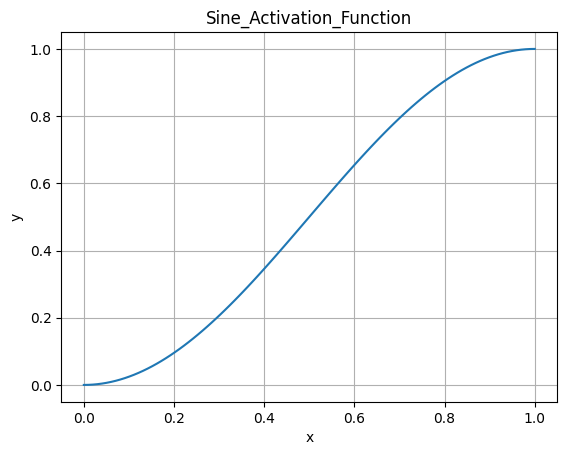

In [12]:
plot_sine_activation()

Print out model details including graph

Output = 461.74688720703125
{'fc1.weight': Parameter containing:
tensor([[ 9.8991e-01,  1.9372e-01, -4.1029e-01,  4.6165e-01,  3.4530e-01,
         -3.2734e-01,  2.2986e-01,  3.6060e-01,  2.3139e-01, -3.6633e-01,
         -6.8067e-01,  1.1938e-01, -2.6410e-01,  5.1893e-02],
        [ 4.6975e-01,  1.1330e+00,  2.8491e-01, -4.7379e-01, -1.1572e-01,
          8.7277e-02,  4.3570e-01,  5.1879e-01,  2.6453e-01, -7.2062e-01,
         -7.3143e-01,  4.2949e-01,  3.2579e-01, -1.7531e-01],
        [ 1.2082e-01, -4.2553e-01,  1.0572e+00,  4.3693e-02,  2.9854e-02,
         -3.6425e-01,  5.7560e-01, -6.8883e-01, -2.9722e-01,  9.2417e-01,
         -2.1739e-01,  2.8610e-01,  1.4305e-01,  5.5637e-02],
        [-1.2910e-03, -5.9521e-01, -5.4122e-01,  5.3887e-01,  1.2828e+00,
         -3.7289e-01, -1.6501e-01,  5.8345e-01,  2.1334e-02,  8.6112e-01,
          6.7069e-02, -7.9354e-01,  1.1194e+00, -4.2134e-01],
        [ 3.2857e-02,  3.1059e-01, -3.2162e-01, -9.0136e-01,  2.0799e+00,
          9.9495e-01,

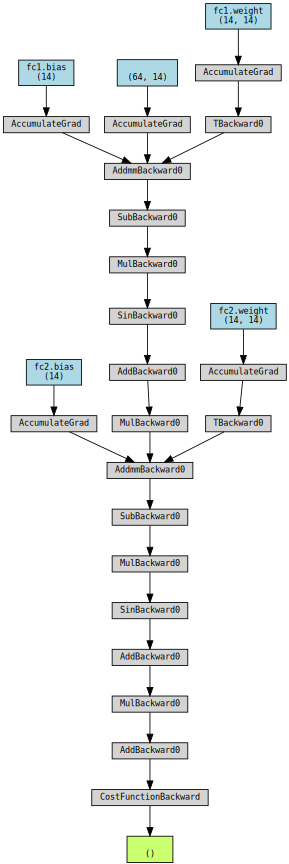

In [13]:
output = model(my_input)
lowest_cost = float(output)
print(f'Output = {output}')
filename = Path(GRAPH_DIR).joinpath('torchviz')

param_dict = dict(model.named_parameters())
print(param_dict)  # Debugging: print the parameters to ensure they seem reasonable
make_dot(output, params=param_dict).render(filename, format="png")
make_dot(output, params=param_dict)

In [14]:
target = torch.tensor(0.0, requires_grad=True)
criterion = nn.L1Loss()
if OPTIMIZER == 'Adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
elif OPTIMIZER == 'SGD':
    optimizer = torch.optim.SGD(model.parameters(), momentum=MOMENTUM, lr=LR, weight_decay=WEIGHT_DECAY)
elif OPTIMIZER == 'RMSprop':
    optimizer = torch.optim.RMSprop(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
else:
    raise ValueError(f'Optimizer {OPTIMIZER} not recognized')

In [15]:
epoch_history = []
loss_history = []
epoch_lowest_cost_found = 0
for epoch in range(NUM_EPOCHS):
    epoch_history.append(epoch)
    model_output = model(my_input)
    loss = criterion(model_output, target)
    loss_history.append(float(loss))
    loss.backward()
    optimizer.step()
    if float(model_output ) < lowest_cost:
        lowest_cost = float(loss)
        epoch_lowest_cost_found = epoch
    if epoch % 50 == 0:
        print(f"Epoch {epoch}, Cost: {loss:.3f}, Lowest Cost to date =  {lowest_cost:.3f}")
        # Check gradients
        for name, param in model.named_parameters():
            if param.grad is not None:
                print(f'Epoch {epoch}, {name} grad: {param.grad.norm():.2f}')
            else:
                print(f'Epoch {epoch}, {name} grad is None')

    optimizer.zero_grad()

print(f'The lowest cost found was {lowest_cost:.3f} at epoch {epoch_lowest_cost_found}.')
print(f'The best known cost is {best_dist:.3f} and the hot start cost was {float(distance_tensor):.3f}.')


Epoch 0, Cost: 459.984, Lowest Cost to date =  459.984
Epoch 0, fc1.weight grad: 53349.02
Epoch 0, fc1.bias grad: 21779.64
Epoch 0, fc2.weight grad: 19916.38
Epoch 0, fc2.bias grad: 8635.41
Epoch 50, Cost: 424.605, Lowest Cost to date =  413.255
Epoch 50, fc1.weight grad: 12550.94
Epoch 50, fc1.bias grad: 5123.90
Epoch 50, fc2.weight grad: 6848.42
Epoch 50, fc2.bias grad: 2912.10
Epoch 100, Cost: 396.105, Lowest Cost to date =  393.739
Epoch 100, fc1.weight grad: 11326.87
Epoch 100, fc1.bias grad: 4624.18
Epoch 100, fc2.weight grad: 10090.53
Epoch 100, fc2.bias grad: 4336.51
Epoch 150, Cost: 385.934, Lowest Cost to date =  384.300
Epoch 150, fc1.weight grad: 4280.20
Epoch 150, fc1.bias grad: 1747.38
Epoch 150, fc2.weight grad: 5772.07
Epoch 150, fc2.bias grad: 2503.41
Epoch 200, Cost: 385.934, Lowest Cost to date =  384.300
Epoch 200, fc1.weight grad: 1934.79
Epoch 200, fc1.bias grad: 789.87
Epoch 200, fc2.weight grad: 2793.95
Epoch 200, fc2.bias grad: 1216.92
Epoch 250, Cost: 384.300,

Plot loss ratio by epoch:

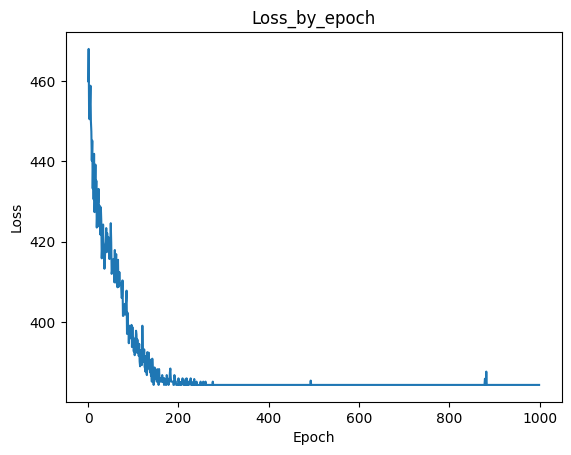

In [16]:
plot_model_training(epoch_history, loss_history)

In [17]:
for layer in model.children():
    if isinstance(layer, nn.Linear):
        print('weight:', layer.weight)
        print('bias:', layer.bias)

weight: Parameter containing:
tensor([[ 8.7852e-01,  2.1918e-01, -3.0050e-01,  3.5154e-01,  3.7076e-01,
         -3.0188e-01,  1.2273e-01,  3.8606e-01,  1.2422e-01, -2.5691e-01,
         -5.6977e-01,  2.1222e-02, -2.3864e-01,  7.7354e-02],
        [ 3.5960e-01,  1.1356e+00,  1.7653e-01, -3.6361e-01, -1.1304e-01,
          8.9958e-02,  3.2574e-01,  5.2147e-01,  1.5654e-01, -6.0963e-01,
         -6.2042e-01,  3.1957e-01,  3.2847e-01, -1.7263e-01],
        [ 2.2354e-02, -4.1941e-01,  9.4574e-01,  1.0425e-16,  3.5965e-02,
         -3.5814e-01,  4.6500e-01, -6.8272e-01, -1.8864e-01,  8.1285e-01,
         -1.1066e-01,  1.7770e-01,  1.4916e-01,  6.1747e-02],
        [-1.1631e-43, -6.1354e-01, -4.3074e-01,  4.2840e-01,  1.2645e+00,
         -3.9122e-01, -6.0954e-02,  5.6512e-01,  1.1813e-42,  7.4989e-01,
          1.2183e-05, -6.8242e-01,  1.1010e+00, -4.3966e-01],
        [ 7.5005e-34,  3.0327e-01, -2.1270e-01, -7.9007e-01,  2.0726e+00,
          9.8763e-01, -3.8858e-01,  2.3485e-01, -3.7267e